# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle


# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

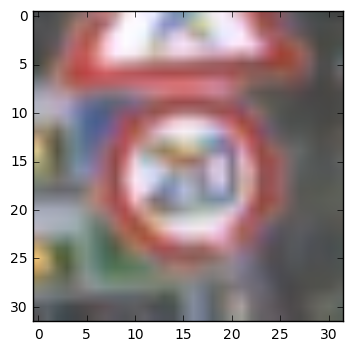

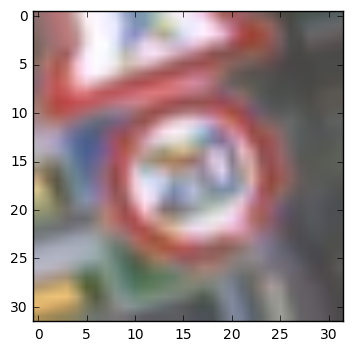

/Users/magnus/anaconda/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


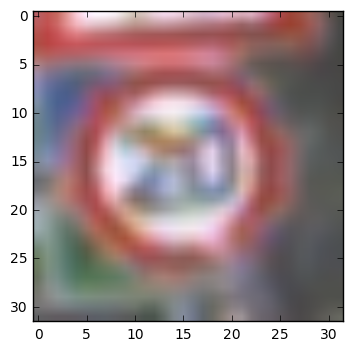

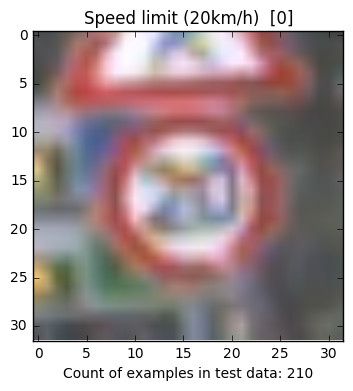

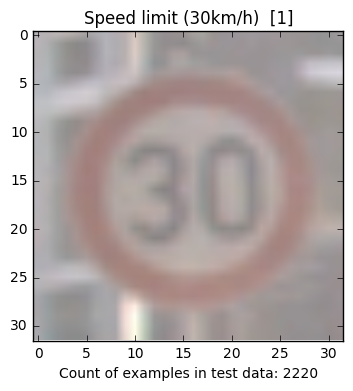

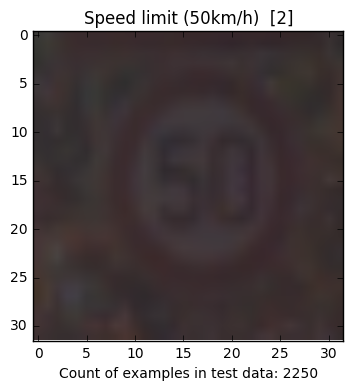

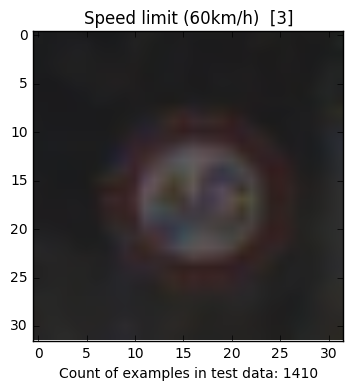

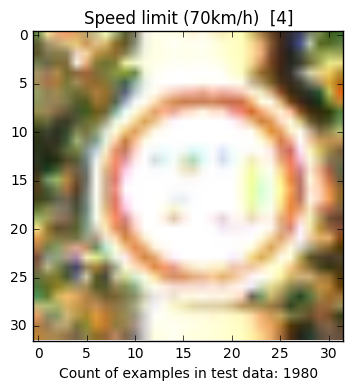

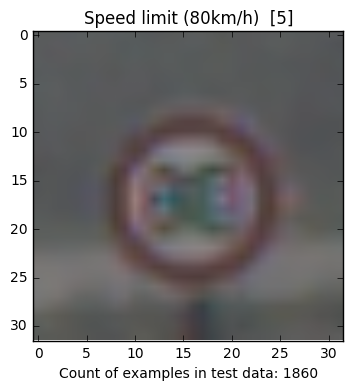

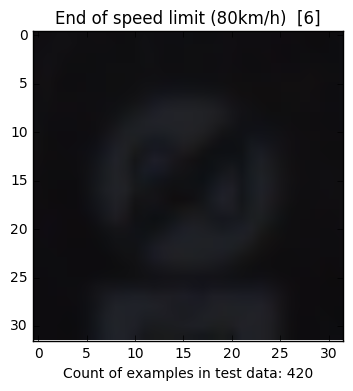

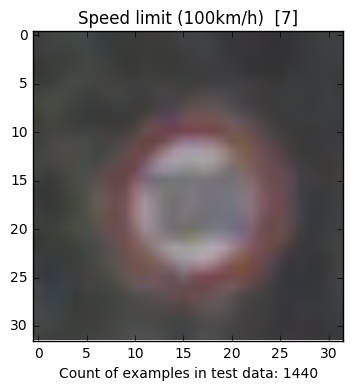

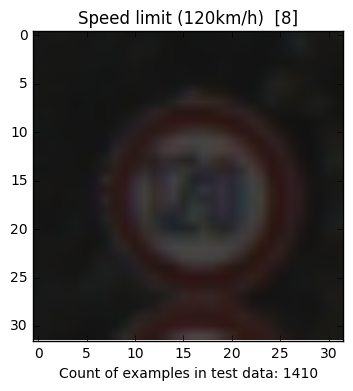

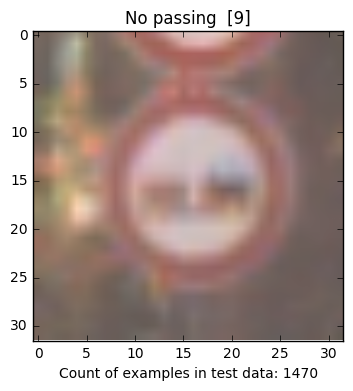

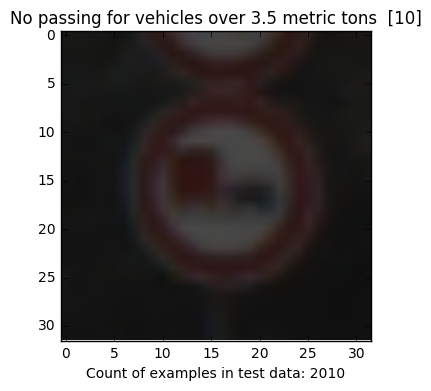

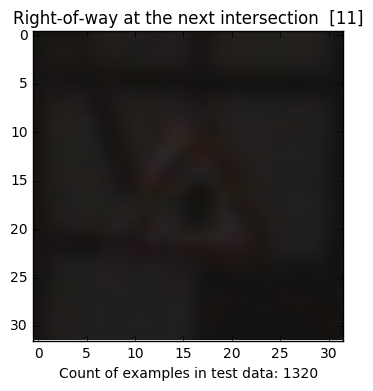

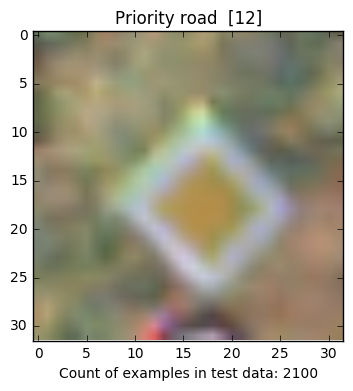

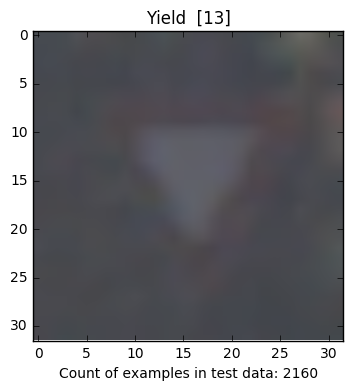

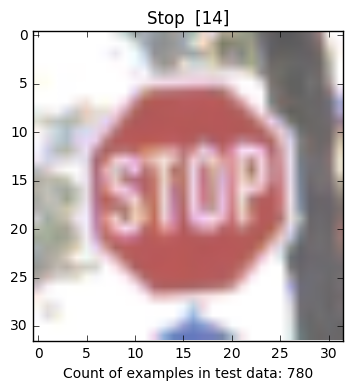

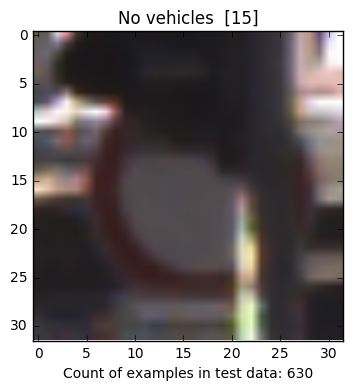

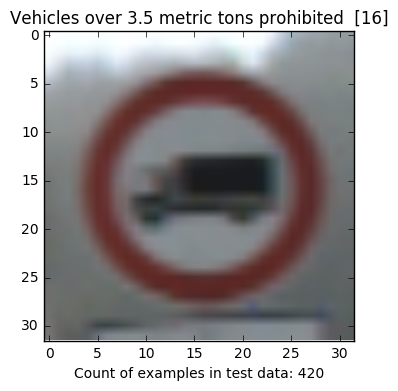

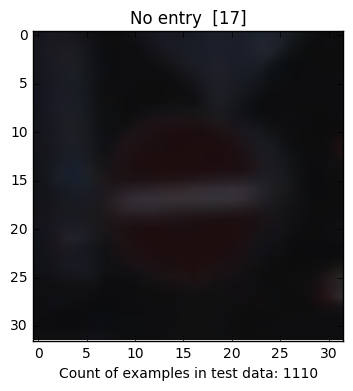

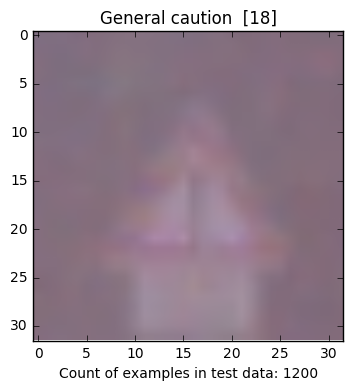

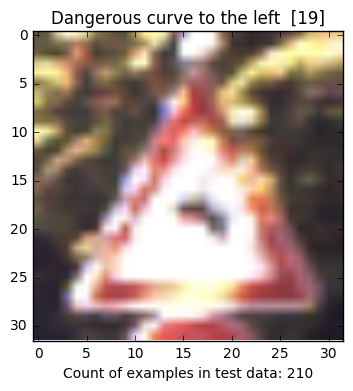

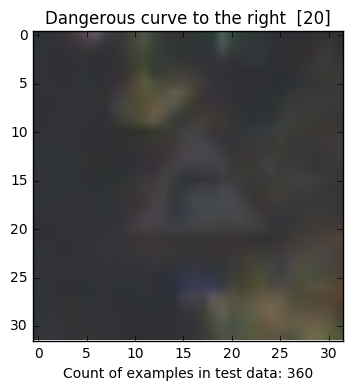

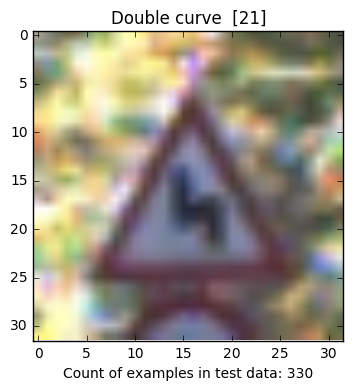

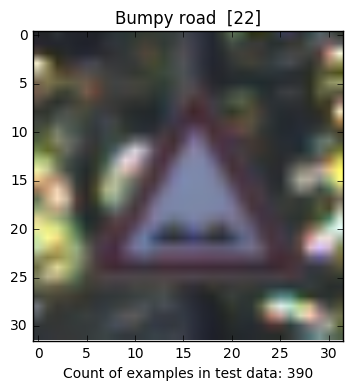

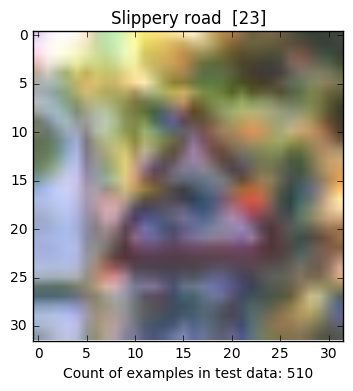

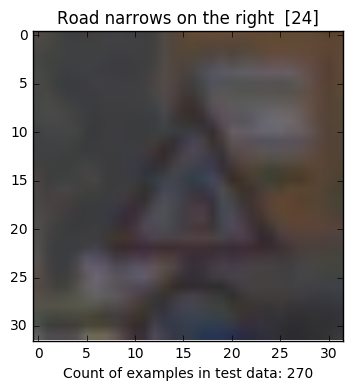

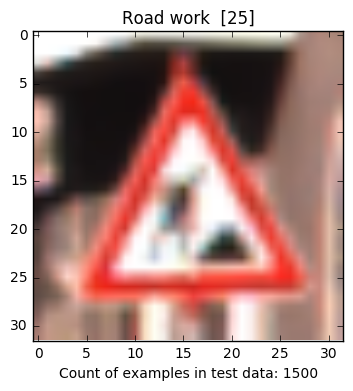

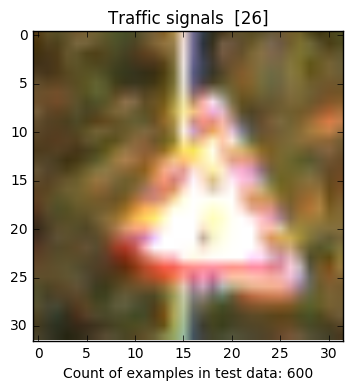

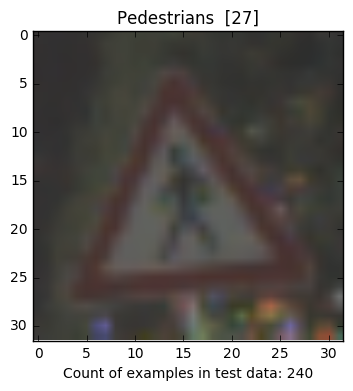

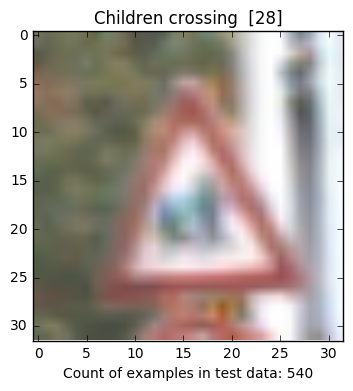

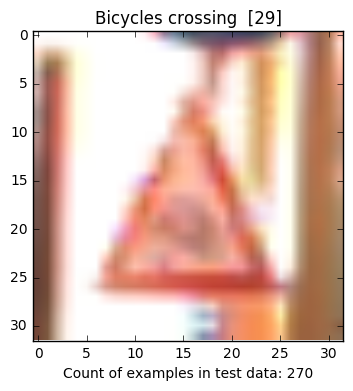

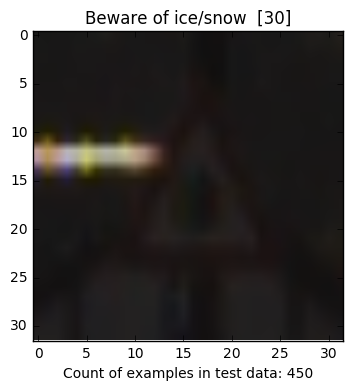

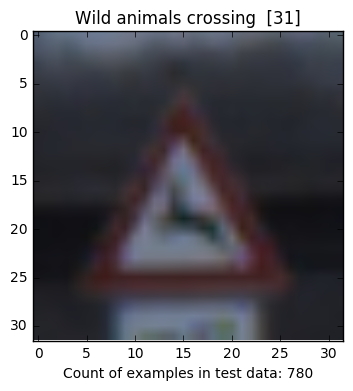

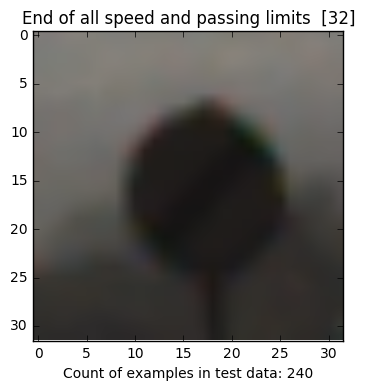

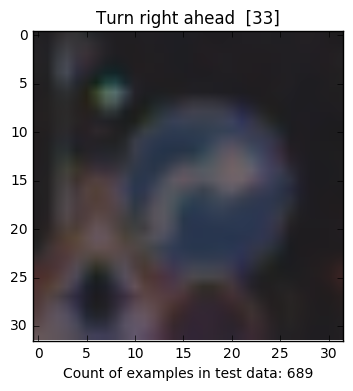

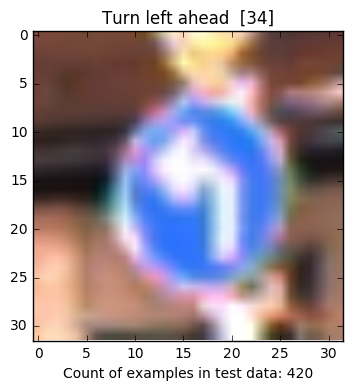

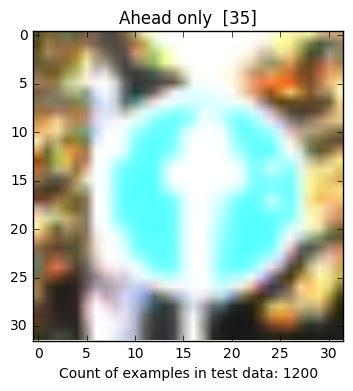

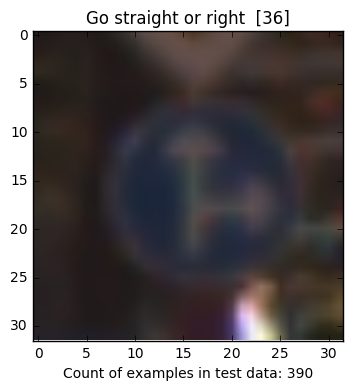

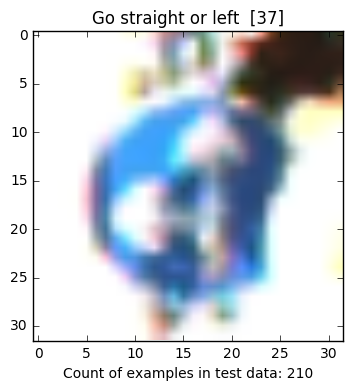

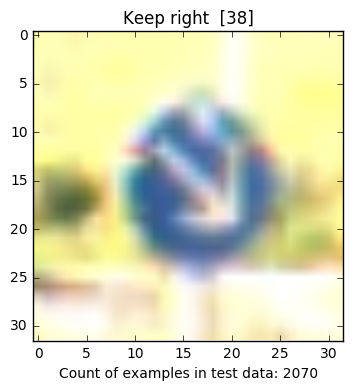

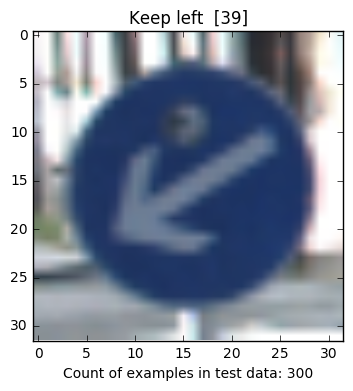

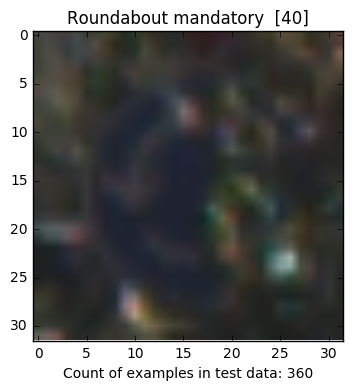

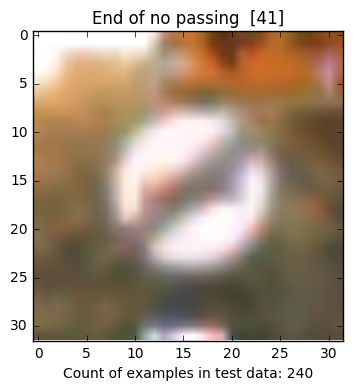

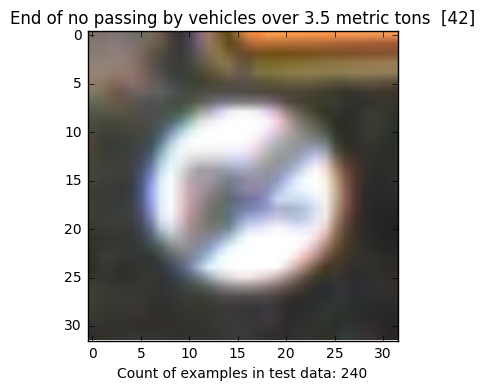

In [26]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage.interpolation import rotate
from scipy.ndimage.interpolation import zoom

# Visualizations will be shown in the notebook.
%matplotlib inline

def rgbToGray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # width and height of the zoomed image
    zh = int(np.round(zoom_factor * h))
    zw = int(np.round(zoom_factor * w))

    # for multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # zooming out
    if zoom_factor < 1:
        # bounding box of the clip region within the output array
        top = (h - zh) // 2
        left = (w - zw) // 2
        # zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # zooming in
    elif zoom_factor > 1:
        # bounding box of the clip region within the input array
        top = (zh - h) // 2
        left = (zw - w) // 2
        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)
        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # if zoom_factor == 1, just return the input array
    else:
        out = img
    return out


def load_sign_names():
    from csv import reader

    with open('signnames.csv', mode='r') as infile:
        signnames = dict((rows[0], rows[1]) for rows in reader(infile))
        return signnames


sign_names = load_sign_names()


plt.imshow(X_train[0])
plt.show()
plt.imshow(rotate(X_train[0],15.0, reshape=False, mode='nearest'))
plt.show()
plt.imshow(clipped_zoom(X_train[0],1.2))
plt.show()



sign_classes = set(y_train)
for class_index in sign_classes:
    data_for_class = [index for index in range(len(y_train)) if y_train[index] == class_index]
    index = data_for_class[0]
    plt.imshow(X_train[index])
    plt.title(sign_names[str(y_train[index])] + "  [" + str(y_train[index]) +"]")
    plt.xlabel("Count of examples in test data: " + str(len(data_for_class)))
    plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [27]:
from scipy.ndimage.interpolation import rotate
from scipy.ndimage.interpolation import zoom
import numpy as np
from numpy.random import random

def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # width and height of the zoomed image
    zh = int(np.round(zoom_factor * h))
    zw = int(np.round(zoom_factor * w))

    # for multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # zooming out
    if zoom_factor < 1:
        # bounding box of the clip region within the output array
        top = (h - zh) // 2
        left = (w - zw) // 2
        # zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # zooming in
    elif zoom_factor > 1:
        # bounding box of the clip region within the input array
        top = (zh - h) // 2
        left = (zw - w) // 2
        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)
        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # if zoom_factor == 1, just return the input array
    else:
        out = img
    if out.shape != img.shape:
        print(out.shape)
    return out

#Create a rotated set
rotated = [rotate(im, (random() - 0.5) * 30.0, reshape=False, mode='nearest') for im in X_train]
rotated2 = [rotate(im, (random() - 0.5) * 30.0, reshape=False, mode='nearest') for im in X_train]


#Crate a zoomed set
zoomed = [clipped_zoom(im, 1.0 + random() * 0.3) for im in X_train]

X_train = np.concatenate([X_train, rotated, rotated2, zoomed])
y_train = np.concatenate([y_train, y_train, y_train, y_train])

from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

R shape (32, 32, 3)


/Users/magnus/anaconda/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [105]:
import tensorflow as tf

EPOCHS = 8
BATCH_SIZE = 128

from tensorflow.contrib.layers import flatten
from tensorflow.contrib.layers.python.layers import batch_norm

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0.0
    sigma = 0.05
    
    x = batch_norm(x)
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [106]:
from sklearn.utils import shuffle

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        print("EPOCH {} ...".format(i+1))    
        validation_accuracy = evaluate(X_validation, y_validation)
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
        print()
    
    print("Validation Accuracy = {:.3f} Epochs={}, BATCHSIZE={}, rate={}".format(validation_accuracy, EPOCHS, BATCH_SIZE, rate))
    saver.save(sess, './lenet')
    print("Model saved")
    
    #print(sess.run(predictions, feed_dict={x: imread("mod/five.png", mode="RGB").reshape(1, 32, 32, 3)}))
    
    

Training...

EPOCH 1 ...
Validation Accuracy = 0.921

EPOCH 2 ...
Validation Accuracy = 0.962

EPOCH 3 ...
Validation Accuracy = 0.977

EPOCH 4 ...
Validation Accuracy = 0.979

EPOCH 5 ...
Validation Accuracy = 0.983

EPOCH 6 ...
Validation Accuracy = 0.983

EPOCH 7 ...
Validation Accuracy = 0.984

EPOCH 8 ...
Validation Accuracy = 0.989

Validation Accuracy = 0.989 Epochs=8, BATCHSIZE=128, rate=0.001
Model saved


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** I tried to convert images to grayscale. The assumption is that enough information is available without colors. That will simplify training and possibly avoid getting stuck in local minimas. I could not detect any noticable improvement. This is discussed in the Sermanet/LeCunn paper and they achieved better results with grayscale images. In fact I had better results with color images.



I applied random noise to improve the learning but I could not notice any improvement and dropped it.




### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** I used the original test data as test data and split the training data into training and validation data. Initially I did this using my own naive implementation (shuffle and splitting) but I noticed that my results improved when using the sklearn.model_selection.train_test_split that considers the test data distribution and makes sure that a good training/validation split is created.

To get a bigger dataset I generating more examples by applying a small random rotatation to the input data set. This doubled the size of training data.

I created even more training data by creating additional training data by zooming into the images. 



### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My model is almost identical to the LeNet provided in the previous exercise. I tried to make smaller adjustments but I could not see any real improvements. The exception was batch normilization which saw some small improvments and I kept it in my model.

It was the generated test data and finding good hyper parameters that were more important. I guess the LeNet architecture was good enough for this problem. Alternative architectures is something I want to explore more but I guess they are harder to tune.

Model Architecture
* Input (32x32x3)
* Conv layer (5x5x3 -> 28x28x6)
* Relu
* maxpool (2x2 kernel, 2x2 stride)
* Conv layer (14x14x6 -> 10x10x16)
* Relu
* maxpool (2x2 kernel, 2x2 stride)
* flatten (5x5x16 -> 400)
* Fully connected 200 -> 120
* Relu
* Fully connected 120 -> 84
* Relu
* Output 84 -> 43



### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** I used the Adam optimizer as recommended in the LeNet-lab. I tried several different values for the hyperparameters by optimizing them one by one. This way of determining hyperparameters worked well in this case but there is a risk of ending up in a local minima as the whole hyperparamter-space is not explored.

The parameter that made the greatest impact was when I found a good value for the sigma parameter(0.05) as the learning quickly converged to a good result. I guess that I found a sweet spot for the weight initialization.

Batch size was 128 and 10 epochs. I got a good result with mu = 0.0 and sigma = 0.05. Learning rate 0.001.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

This was very much a process of trial and error. My first approach was to create my network from scratch using an arcitecture inspired by LeNet and other suggestions I found online in combination with some thoughts of my own.

This did not result in a good result but it was probably due to using a poor algorithm for dividing training and validation data.

My next try was to start with the LeNet-network from the labs an slowly evolve that using data processing and test data generation. There where things I tried (example: drop out) that look promising but didn't provide noticable results. I left them out of my solution but would like to revisit them and play around more with the architecture an even more optimized solution. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [107]:
#Prediction code implementation

from scipy.ndimage import imread

predictions = tf.nn.softmax(logits)

def predict(sess, im):
    return sess.run(predictions, feed_dict={x: im.reshape(1, 32, 32, 3)})


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

I took five images in Sweden. Swedish traffic signs are similar to german signs but not identical. There are differences in color, typography and general design.

The images are of good quality when compared to the german data set. They were shot using an iphone in the morning. In some shots there is some motion blur present. Motion blur most likely make it harder to predict as some information is lost. Motion blur is present in the training data as well and should be handled by the system.   

The success of the neural network will depend on how it generalizes these properties. The prediction of swedish signs would probably work better if the data was converted to grayscale before traning/prediction as color is a property that differs between the two countries.

The images are listed below with some comments on what differs and what could cause problems.


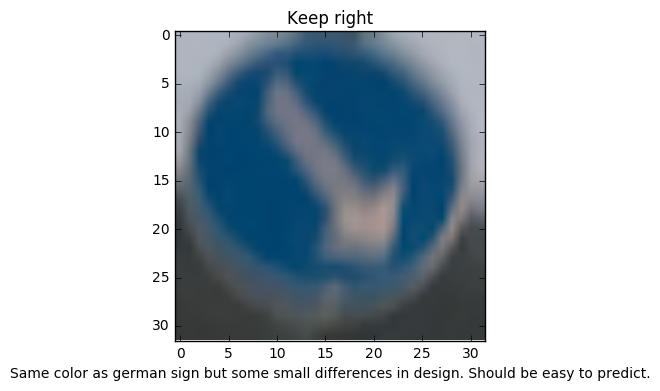

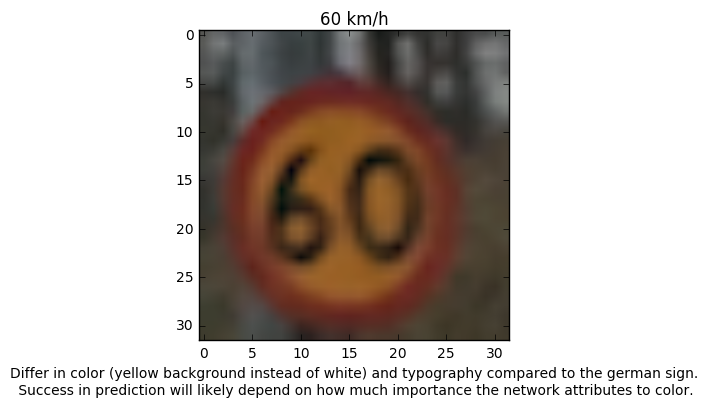

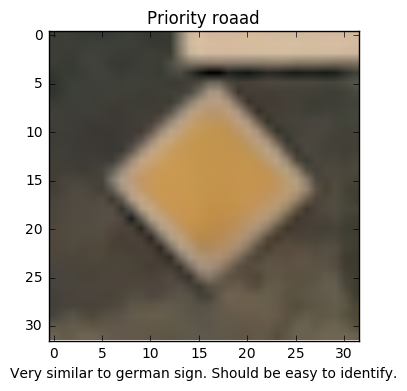

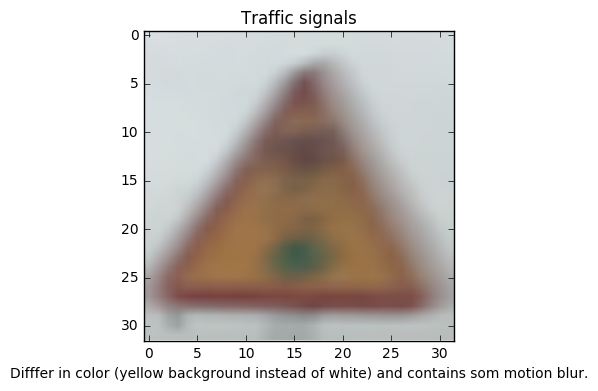

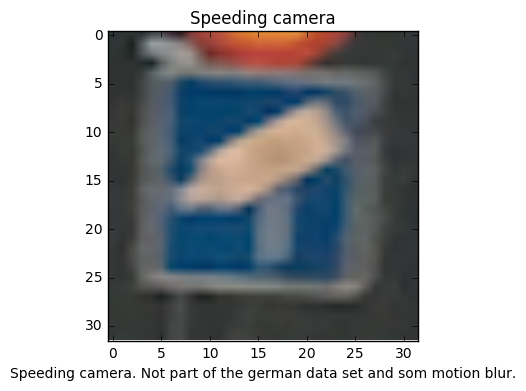

In [23]:
from scipy.ndimage import imread
import matplotlib.pyplot as plt

def display_image(im, title, subtitle=None):
    plt.imshow(im)
    plt.imshow(im)
    plt.title(title)
    if subtitle != None:
        plt.xlabel(subtitle)
    plt.show()



display_image(imread("mod/one.png", mode="RGB"), "Keep right", subtitle="Same color as german sign but some small differences in design. Should be easy to predict.")
display_image(imread("mod/two.png", mode="RGB"), "60 km/h", subtitle="Differ in color (yellow background instead of white) and typography compared to the german sign.\n Success in prediction will likely depend on how much importance the network attributes to color.")
display_image(imread("mod/three.png", mode="RGB"), "Priority roaad", subtitle="Very similar to german sign. Should be easy to identify.")
display_image(imread("mod/four.png", mode="RGB"), "Traffic signals", subtitle="Difffer in color (yellow background instead of white) and contains som motion blur.")
display_image(imread("mod/five.png", mode="RGB"), "Speeding camera", subtitle="Speeding camera. Not part of the german data set and som motion blur.")

In [108]:
from scipy.ndimage import imread

def display_image(im, title, subtitle=None):
    plt.imshow(im)
    plt.title(title)
    if subtitle != None:
        plt.xlabel(subtitle)
    plt.show()


"""
display_image(im1, "First image", subtitle=prediction_title)

display_image("mod/two.png", "Second image")
display_image("mod/three.png", "Third image")
display_image("mod/four.png", "Fourth image", subtitle="Not part of german data set.")
display_image("mod/five.png", "Fifth image", subtitle="Not part of german data set.")
"""


### Run the predictions here.
### Feel free to use as many code cells as needed.
if saver == None:
    saver = tf.train.Saver()
    
with tf.Session() as sess:
    saver.restore(sess, './lenet') # tf.train.latest_checkpoint('.'))
    
    im1 = imread("mod/one.png", mode="RGB")
    pred1 = predict(sess, im1)

    im2 = imread("mod/two.png", mode="RGB")
    pred2 = predict(sess, im2)

    im3 = imread("mod/three.png", mode="RGB")
    pred3 = predict(sess, im3)

    im4 = imread("mod/four.png", mode="RGB")
    pred4 = predict(sess, im4)

    im5 = imread("mod/five.png", mode="RGB")
    pred5 = predict(sess, im5)
    
    
print("Predictions done!")


Predictions done!


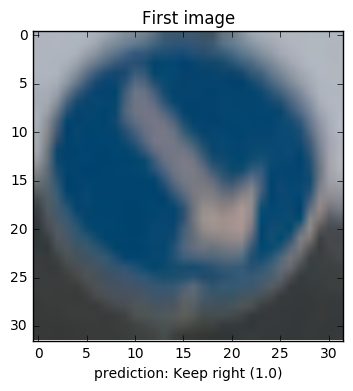

In [109]:
### First image
max_prediction_index = np.argmax(pred1)
max_prediction = np.max(pred1)
prediction_title = "prediction: " + sign_names[str(max_prediction_index)] + " (" + str(max_prediction) + ")"
display_image(im1, "First image", subtitle=prediction_title)


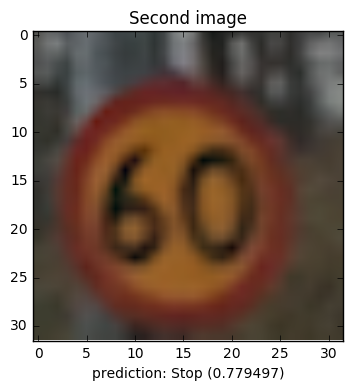

In [115]:
### Second image
max_prediction_index = np.argmax(pred2)
max_prediction = np.max(pred2)
prediction_title = "prediction: " + sign_names[str(max_prediction_index)] + " (" + str(max_prediction) + ")"
display_image(im2, "Second image", subtitle=prediction_title)


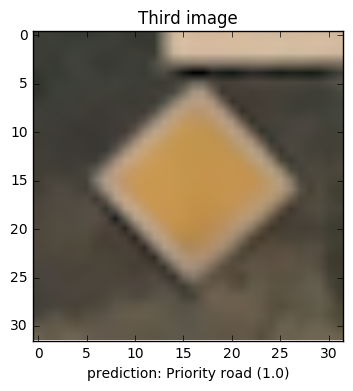

In [111]:
### Third image
max_prediction_index = np.argmax(pred3)
max_prediction = np.max(pred3)
prediction_title = "prediction: " + sign_names[str(max_prediction_index)] + " (" + str(max_prediction) + ")"
display_image(im3, "Third image", subtitle=prediction_title)

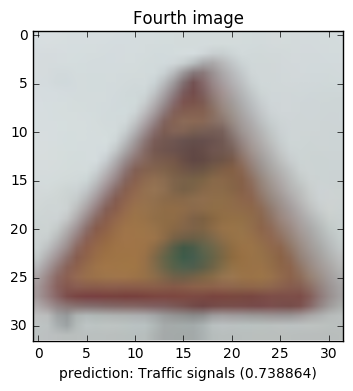

In [112]:
### Fourth image
max_prediction_index = np.argmax(pred4)
max_prediction = np.max(pred4)
prediction_title = "prediction: " + sign_names[str(max_prediction_index)] + " (" + str(max_prediction) + ")"
display_image(im4, "Fourth image", subtitle=prediction_title)

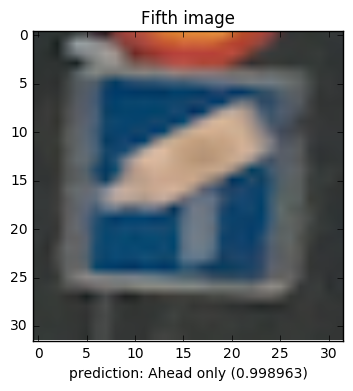

In [113]:
### Fifth image
max_prediction_index = np.argmax(pred5)
max_prediction = np.max(pred5)
prediction_title = "prediction: " + sign_names[str(max_prediction_index)] + " (" + str(max_prediction) + ")"
display_image(im5, "Fifth image", subtitle=prediction_title)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

It's not performing quite as well. Out of my 5 images there are four that are available in the german traffic sign data set. Three out of four were identified correctly and that gives that it's 75% accurate. 

The neural network fails to identify the 60 km/h sign (illustrated below). My data is collected in Sweden and the speed limit signs and some other sign differ slightly. The swedish and german 60 km/h signs differ in color and typography. It's obvious that the neural network failed to generalize them. Using grey images and skewing could help the network generalize. The network succeds in identifying the traffic light sign despite that they are differentely colored.

To me it's seems that the correct soultion is to add variations of the signs that contains example from all around the world. Simply using german traffic signs is not enough when identifying traffic signs outside of Germany. 


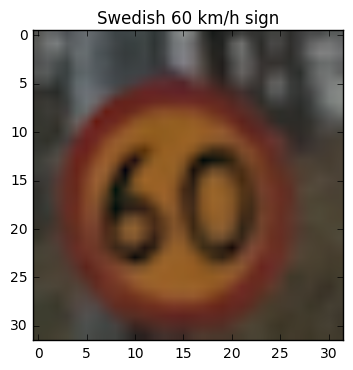

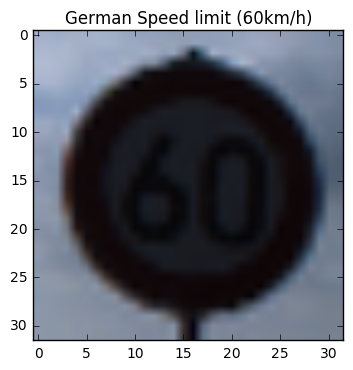

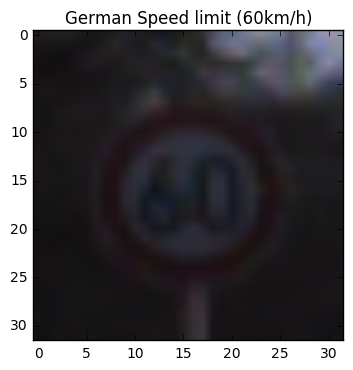

In [124]:
display_image(im2, "Swedish 60 km/h sign")


data_for_class = [index for index in range(len(y_train)) if y_train[index] == 3]
index = data_for_class[0]
plt.imshow(X_train[index])
plt.title("German " + sign_names[str(y_train[index])])
plt.show()
index = data_for_class[1]
plt.imshow(X_train[index])
plt.title("German " + sign_names[str(y_train[index])])
plt.show()




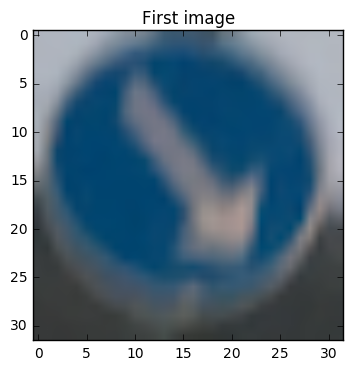

1.000 	 Keep right
0.000 	 Turn left ahead
0.000 	 Go straight or right
0.000 	 Ahead only
0.000 	 Children crossing


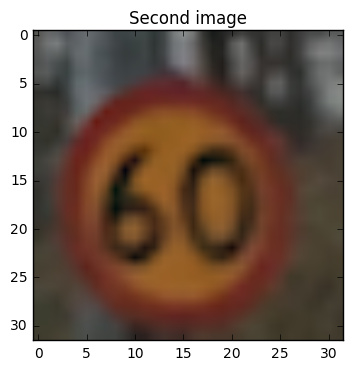

0.779 	 Stop
0.217 	 Bicycles crossing
0.002 	 Speed limit (20km/h)
0.001 	 Road work
0.000 	 No entry


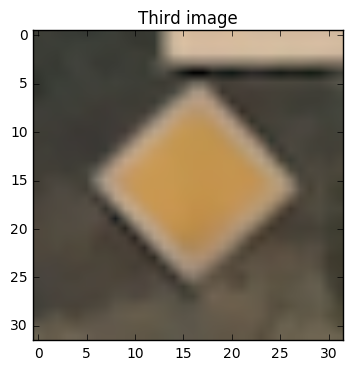

1.000 	 Priority road
0.000 	 No passing
0.000 	 No entry
0.000 	 Yield
0.000 	 End of no passing


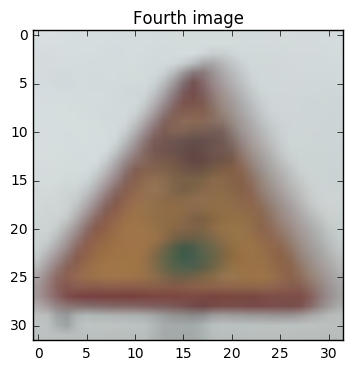

0.739 	 Traffic signals
0.242 	 Stop
0.015 	 Beware of ice/snow
0.002 	 Bumpy road
0.001 	 Dangerous curve to the right


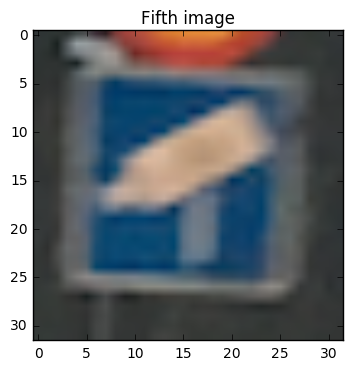

0.999 	 Ahead only
0.001 	 Turn right ahead
0.000 	 Keep left
0.000 	 Go straight or left
0.000 	 No passing


In [150]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

if saver == None:
    saver = tf.train.Saver()

def top5(sess, pred):
    return sess.run(tf.nn.top_k(tf.constant(pred), k=5))
    
def print_top_5(sess, pred):
    index = 1
    top_entries = top5(sess, pred)
    for (prob, sign_index) in zip(top_entries.values[0], top_entries.indices[0]):
        print("%.3f" % prob, "\t", sign_names[str(sign_index)])
    
with tf.Session() as sess:
    saver.restore(sess, './lenet') # tf.train.latest_checkpoint('.'))
    
    display_image(im1, "First image")
    print_top_5(sess, pred1)
    print("======================================================")
    
    display_image(im2, "Second image")
    print_top_5(sess, pred2)
    print("======================================================")
    
    display_image(im3, "Third image")
    print_top_5(sess, pred3)
    print("======================================================")
    
    display_image(im4, "Fourth image")
    print_top_5(sess, pred4)
    print("======================================================")

    display_image(im5, "Fifth image")
    print_top_5(sess, pred5)
    print("======================================================")



### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:** The model is very certain of "Priority Road" and "Keep Right" signs. The swedish signs for these are identical to the german ones. It is also very certain of the "Ahead only" identification despite of the fact that it is incorrect. This sign is not present in the german data set. It certainly resembles the "Ahead only" sign.

It is moderately certain of the "Traffic signals" and "60 km/h" sign. Both are of swedish origin and differ in color when compared to the german signs. One prediction is correct and one is incorrect. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.